In [1]:
!pip install emoji
!pip install mawo_pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 2.2 MB/s eta 0:00:0000:0100:01m


In [2]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter

import emoji
import nltk
from nltk.corpus import stopwords
from mawo_pymorphy3 import create_analyzer

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
import joblib

# EDA

## Загрузка датасета

Формат датасета:
- text — текст отзыва
- label — числовая метка тональности (0, 1, 2)
- src — источник данных (например, rureviews)

In [ ]:
# Для Colab
# import gdown

# file_id = "1e-sTvQRZsx2dPjAvkjRSdbWDQ1ra1zAJ"
# url = f'https://drive.google.com/uc?id={file_id}'
# output = 'file.zip'

# gdown.download(url, output, quiet=False)

# import zipfile
# with zipfile.ZipFile(output, 'r') as zip_ref:
#     zip_ref.extractall('.')
#     print("Файлы распакованы!")

# import os
# print("Содержимое папки:")
# print(os.listdir('.'))

In [ ]:
# df = pd.read_csv('ТОНАЛЬНОСТЬ/train.csv')
# test = pd.read_csv('ТОНАЛЬНОСТЬ/test.csv')
# df.head()

In [ ]:
# Для локального запуска

# DATA_DIR = Path(os.getcwd()) / 'data'
# TRAIN_DATASET_PATH = DATA_DIR / 'train.csv'
# TEST_DATASET_PATH = DATA_DIR / 'test.csv'

# df = pd.read_csv(TRAIN_DATASET_PATH)
# test = pd.read_csv(TEST_DATASET_PATH)
# df.head()

In [3]:
df = pd.read_csv('../input/train-ds/train.csv')
df.head()

,ID,text,src,label
0,26739,smaller than in description.,rureviews,0
1,198426,Слева от меня Алексей Ильмухин. Путешественник...,rusentiment,1
2,172615,"Ребёнок в садик отходил год, из них пол года п...",geo,2
3,246532,Замерзла на -15,perekrestok,2
4,209852,"Как всегда, название не соответствует истинном...",kinopoisk,0


Проверим пропуски.

In [5]:
print(f'Всего строк: {len(df)}')
df[df['text'].isna()]

Всего строк: 232366


,ID,text,src,label


## Анализ классов и источников

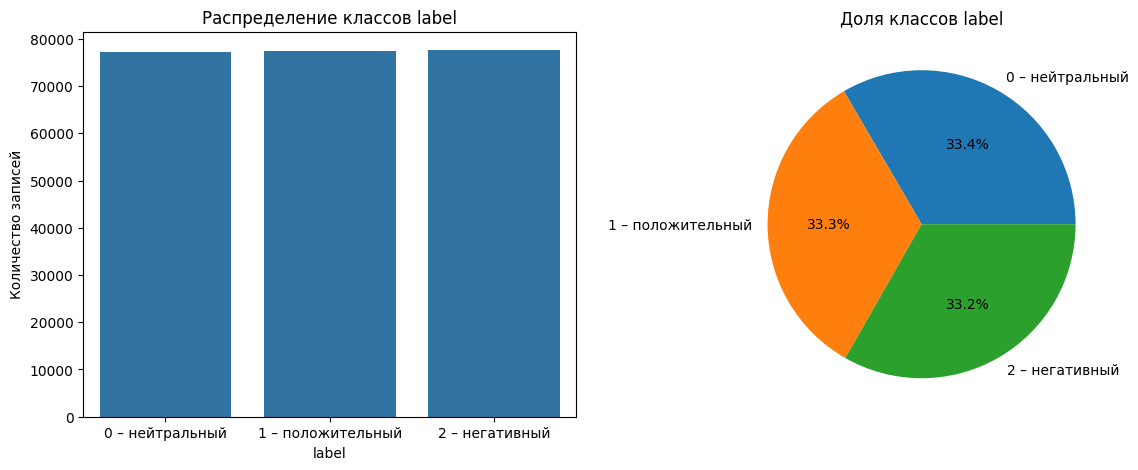

In [6]:
# Анализ label
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x='label', ax=ax1)
ax1.set_title('Распределение классов label')
ax1.set_xlabel('label')
ax1.set_ylabel('Количество записей')
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['0 – нейтральный', '1 – положительный', '2 – негативный'])

ax2.pie(df['label'].value_counts(normalize=True) * 100, autopct='%.1f%%', labels=['0 – нейтральный', '1 – положительный', '2 – негативный'])
ax2.set_title('Доля классов label')

plt.show()

/tmp/ipykernel_55/1118674685.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(src_counts.index, rotation=45, ha='right')


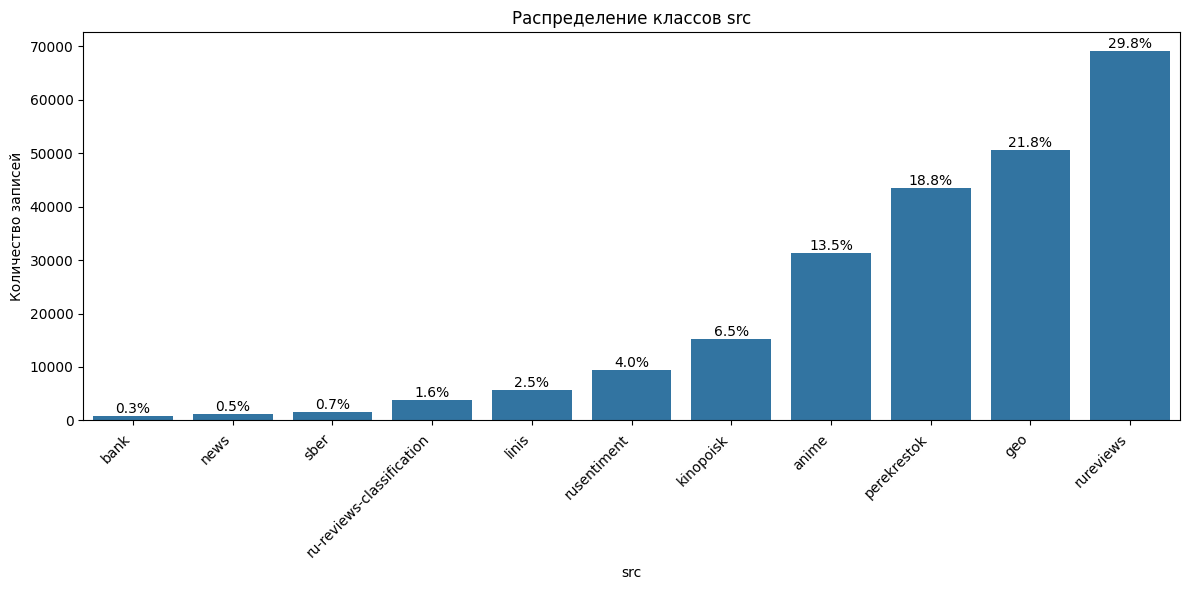

In [7]:
# Анализ src
plt.figure(figsize=(12, 6))
ax = plt.gca()

src_counts = df['src'].value_counts().sort_values()

bars = sns.countplot(data=df, x='src', ax=ax, order=src_counts.index)
ax.set_title('Распределение классов src')
ax.set_xlabel('src')
ax.set_ylabel('Количество записей')
ax.set_xticklabels(src_counts.index, rotation=45, ha='right')
ax.tick_params(axis='x', which='major', pad=5)

total = len(df)
for i, (bar, count) in enumerate(zip(bars.patches, src_counts.values)):
    height = bar.get_height()
    percentage = (count / total) * 100
    ax.text(bar.get_x() + bar.get_width() / 2., height + 0.1,
            f'{percentage:.1f}%',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

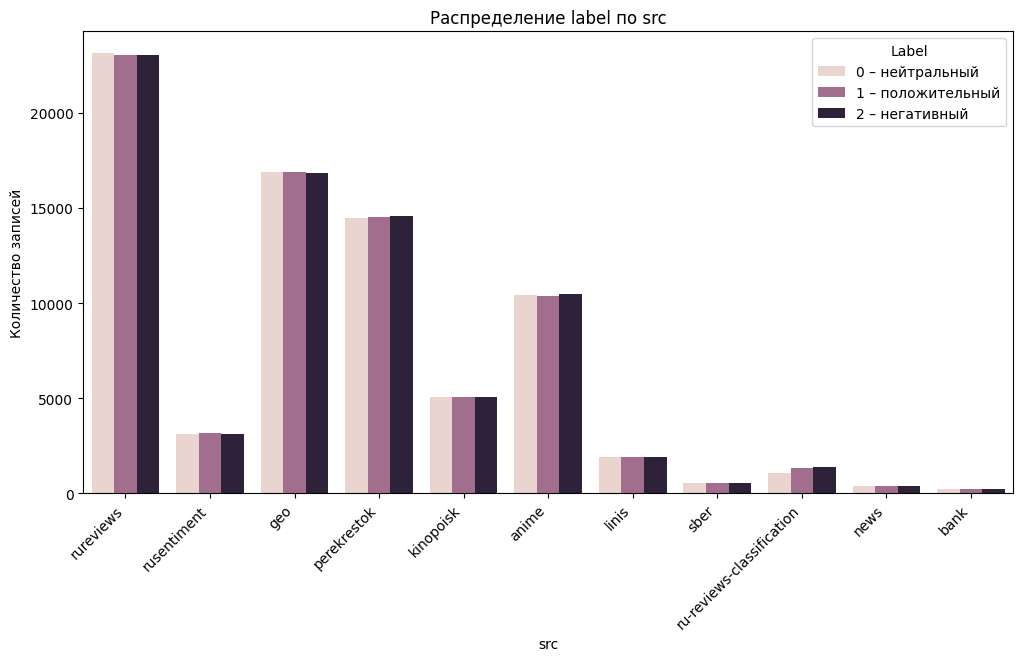

In [8]:
# Анализ распределения label по src
plt.figure(figsize=(12, 6))

# Создаем группированную гистограмму
sns.countplot(data=df, x='src', hue='label')
plt.title('Распределение label по src')
plt.xlabel('src')
plt.ylabel('Количество записей')
plt.legend(title='Label', labels=['0 – нейтральный', '1 – положительный', '2 – негативный'])
plt.xticks(rotation=45, ha='right')

plt.show()

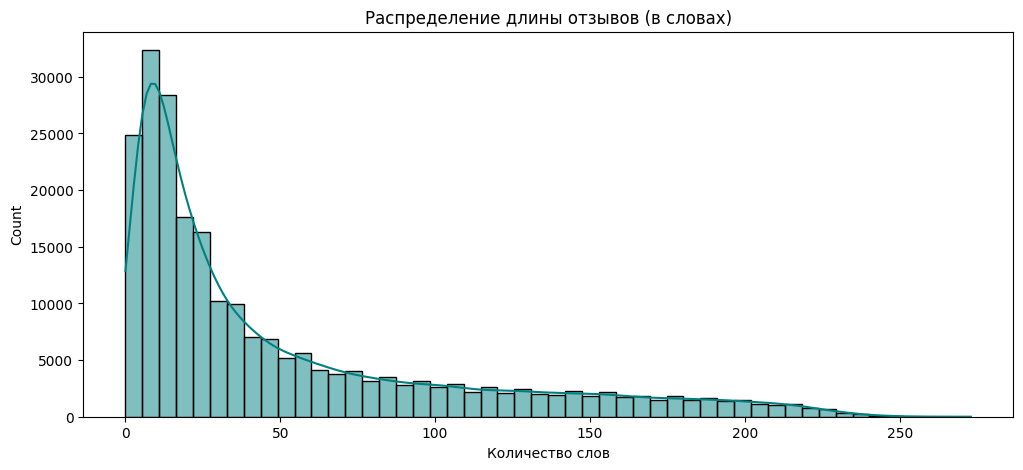

Средняя длина: 51.2 слов
Максимальная длина: 273.0 слов
95-й перцентиль: 180.0 слов
99-й перцентиль: 218.0 слов


In [9]:
# Длина тектов в словах
# Пригодится для BERT
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
sns.histplot(df['word_count'], bins=50, kde=True, color='teal')
plt.title('Распределение длины отзывов (в словах)')
plt.xlabel('Количество слов')
plt.show()

print(f"Средняя длина: {df['word_count'].mean():.1f} слов")
print(f"Максимальная длина: {df['word_count'].max():.1f} слов")
print(f"95-й перцентиль: {df['word_count'].quantile(0.95):.1f} слов")
print(f"99-й перцентиль: {df['word_count'].quantile(0.99):.1f} слов")

In [10]:
# Поиск дубликатов
duplicates = df.duplicated(subset=['text', 'label'], keep='first').sum()
print(f"Дубликаты (текст + лейбл): {duplicates}")

# Поиск противоречий label в дубликатах
text_label_counts = df.groupby('text')['label'].nunique()
conflicting_texts = text_label_counts[text_label_counts > 1]
print(f"Противоречия label в дубликатах: {len(conflicting_texts)}")

examples = conflicting_texts.head(3).index.tolist()
bad_df = df[df['text'].isin(examples)].sort_values('text')
display(bad_df[['text', 'label', 'src']])

Дубликаты (текст + лейбл): 21
Противоречия label в дубликатах: 19


,text,label,src
86966,Все понравилось,0,perekrestok
139423,Все понравилось,1,rureviews
168664,Маленькая,0,perekrestok
184633,Маленькая,2,rureviews
150660,Маленький размер,2,rureviews
196407,Маленький размер,0,perekrestok


Итого:
- Дисбаланса классов по label нет.
- Разное количество строк с различными src.
- Дубликатов и противоречий очень мало относительно всего датасета. Их можно просто удалить.

In [11]:
# Из дубликатов удаляем только один
df = df.drop_duplicates(subset=['text', 'label'], keep='first')

# Противоречия удаляем все
text_label_counts_after_drop = df.groupby('text')['label'].nunique()
conflicting_texts_to_drop = text_label_counts_after_drop[text_label_counts_after_drop > 1].index
df = df[~df['text'].isin(conflicting_texts_to_drop)]

print(f'Количество строк в датасете: {len(df)}')

Количество строк в датасете: 232307


# Preprocessing

## Очистка текста

Некоторые отзывы содержат эмодзи. Какие-то из них несут информацию об эмоциях пользователя, какие-то нет.

In [12]:
# Поиск эмодзи
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # эмоции
    "\U0001F300-\U0001F5FF"  # символы и пиктограммы
    "\U0001F680-\U0001F6FF"  # транспорт и карты
    "\U0001F1E0-\U0001F1FF"  # флаги
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "\U0001F900-\U0001F9FF"
    "]+",
    flags=re.UNICODE
)

def extract_all_emojis(text):
    if pd.isna(text):
        return []
    return emoji_pattern.findall(str(text))

all_emojis = []

for text in df['text'].dropna():
    emojis = extract_all_emojis(text)
    all_emojis.extend(emojis)

# Подсчитываем частоту каждого эмодзи
emoji_counter = Counter(all_emojis)

emoji_df = pd.DataFrame({
    'emoji': list(emoji_counter.keys()),
    'count': list(emoji_counter.values()),
    'frequency_percent': [count/len(all_emojis)*100 for count in emoji_counter.values()]
})

emoji_df = emoji_df.sort_values('count', ascending=False).reset_index(drop=True)
emoji_df['rank'] = range(1, len(emoji_df) + 1)

print(f'Всего эмодзи: {len(all_emojis)}')
print(f'Уникальных эмодзи: {len(emoji_df)}')
print('Топ-30 самых частых эмодзи:')

emoji_df.head(30)

Всего эмодзи: 10756
Уникальных эмодзи: 1787
Топ-30 самых частых эмодзи:


,emoji,count,frequency_percent,rank
0,👍,776,7.214578,1
1,♀️,409,3.802529,2
2,❤️,276,2.566010,3
3,😂,217,2.017479,4
4,😊,210,1.952399,5
5,🤦,198,1.840833,6
6,⠀,188,1.747862,7
7,😁,180,1.673485,8
8,🤷,175,1.626999,9
9,👍🏻,152,1.413165,10


Эмодзи очевидно несут некий эмоциональный посыл (по сути они для этого и созданы), так что лучше их оставить.
Возьмем топ-30 популярных эмодзи и закодируем их в отдельную метку EMOJI_XXX (с названием конкретного эмодзи). Другие эмодзи закодируем в метку EMOJI_OTHER, так как само наличие эмодзи в комментарии тоже может показать его эмоциональный окрас.

In [13]:
def extract_emojis(text):
    return [ch for ch in text if ch in emoji.EMOJI_DATA]

all_emojis = []
for txt in df['text']:
    all_emojis.extend(extract_emojis(str(txt)))

emoji_counts = Counter(all_emojis)

# Топ-30 самых частотных
top_emojis = [e for e, c in emoji_counts.most_common(30)]

# Преобразует топ-30 эмодзи в текстовые теги, остальные заменяет на EMOJI_OTHER
def normalize_emoji(text, top_emojis_set=set(top_emojis)):
    def replace_char(ch):
        if ch in emoji.EMOJI_DATA:
            if ch in top_emojis_set:
                desc = emoji.demojize(ch).strip(":").upper()
                return f"EMOJI_{desc}"
            else:
                return "EMOJI_OTHER"
        else:
            return ch
    new_text = "".join(replace_char(ch) for ch in text)
    return new_text

df['text'] = df['text'].astype(str).apply(normalize_emoji)

In [14]:
import json

# Сохраняем в JSON файл
with open("top_emojis.json", "w", encoding="utf-8") as f:
    json.dump(top_emojis, f, ensure_ascii=False)

print("Топ-30 эмодзи сохранены в top_emojis.json")

Топ-30 эмодзи сохранены в top_emojis.json


In [ ]:
# from google.colab import files

# files.download("top_emojis.json")

Далее очищаем цифры, спецсимволы, двойные пробелы.
Восклицательные и вопросительные знаки решили остаивть, так как они показывают тональность отзыва.

In [15]:
def clean_text(text):
    text = text.lower()
    # Удаляем ссылки
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # Удаляем HTML
    text = re.sub(r'<.*?>', ' ', text)
    # Удаляем упоминания @username
    text = re.sub(r'@\w+', ' ', text)
    # Оставляем буквы, цифры, пробелы и важные эмоциональные символы ! ? .
    # Удаляем весь мусор (#, %, &, { }, <>, и т.п.)
    text = re.sub(r'[^a-zа-яё0-9!?.,…\s]', ' ', text)
    # Заменяем повтор пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['text'] = df['text'].apply(clean_text)
df_before_stopwords = df.copy(deep=True)

In [ ]:
# df.to_csv("train_cleaned_before_stopwords.csv", index=False)
# files.download("train_cleaned_before_stopwords.csv")

После обработки появились пустые строки. Их достаточно мало, так что можем удалить.

In [17]:
df[df['text']=='']

,ID,text,src,label,word_count
21232,33930,,rureviews,1,1
27714,17245,,rureviews,0,1
47387,19969,,rureviews,0,2
78489,72170,,rureviews,2,5
91935,53863,,rureviews,1,1
116853,39140,,rureviews,1,1
122547,232458,,ru-reviews-classification,0,1
130988,35921,,rureviews,1,1
137305,15474,,rureviews,0,1
148575,22812,,rureviews,0,1


In [18]:
df = df[df['text'] != '']

## Токенизация + удаление стоп-слов

In [19]:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

def tokenize_remove_stopwords(text):
    tokens = text.split()  # простая токенизация по пробелу
    tokens = [t for t in tokens if t not in russian_stopwords]
    return " ".join(tokens)

# сделаем 2 отдельных датасета: с и без удаления стоп-слов
df_no_stop = df.copy(deep=True) # без удаления стоп-слов

df['text'] = df['text'].apply(tokenize_remove_stopwords)
df_stop = df.copy(deep=True)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


При удалении стоп-слов появились пустые строки. Их достаточно мало, так что их можно удалить.

In [20]:
print(f'Всего пустых строк при удалении стоп-слов: {len(df_stop[df_stop["text"] == ""])}')
df_stop[df_stop['text'] == '']

Всего пустых строк при удалении стоп-слов: 58


,ID,text,src,label,word_count
4240,247556,,perekrestok,2,2
6404,287410,,perekrestok,1,1
10433,192756,,rusentiment,0,3
24972,245832,,perekrestok,2,2
30053,284129,,perekrestok,1,2
30538,199743,,rusentiment,2,4
37452,257986,,perekrestok,0,1
37970,257124,,perekrestok,0,4
39217,269661,,perekrestok,0,2
48894,15753,,rureviews,0,1


In [22]:
df_stop = df_stop[df_stop['text'] != '']
df_stop[df_stop['text']=='']

,ID,text,src,label,word_count


In [ ]:
# df_no_stop.to_csv("train_cleaned_no_stopwords_before_lemm.csv", index=False)
# df_stop.to_csv("train_cleaned_stopwords_before_lemm.csv", index=False)

## Лемматизация

In [ ]:
# для датасета с удаленными стоп-словами

from tqdm.auto import tqdm
tqdm.pandas()

analyzer = create_analyzer()

def lemmatize_text_mawo(text):
    tokens = text.split()
    lemmas = []
    for token in tokens:
        if token.startswith("EMOJI_"):
            lemmas.append(token)
        else:
            parsed = analyzer.parse(token)
            if parsed:
                lemmas.append(parsed[0].normal_form)
            else:
                lemmas.append(token)
    return " ".join(lemmas)

df_stop['text'] = df_stop['text'].progress_apply(lemmatize_text_mawo)

In [ ]:
# для датасета со стоп-словами

from tqdm.auto import tqdm
tqdm.pandas()

analyzer = create_analyzer()

def lemmatize_text_mawo(text):
    tokens = text.split()
    lemmas = []
    for token in tokens:
        if token.startswith("EMOJI_"):
            lemmas.append(token)
        else:
            parsed = analyzer.parse(token)
            if parsed:
                lemmas.append(parsed[0].normal_form)
            else:
                lemmas.append(token)
    return " ".join(lemmas)

# Применяем с прогресс-баром
df_no_stop['text'] = df_no_stop['text'].progress_apply(lemmatize_text_mawo)

In [ ]:
# from google.colab import files

# df_stop.to_csv("train_cleaned_stopwords_lemm.csv", index=False)
# df_no_stop.to_csv("train_cleaned_no_stopwords_lemm.csv", index=False)
# files.download('train_cleaned_stopwords_lemm.csv')
# files.download('train_cleaned_no_stopwords_lemm.csv')

In [6]:
# лемматизацию сделала в другой версии ноутбука, просто загружу готовые файлы
df_stop = pd.read_csv('/kaggle/input/stopwords-lemm/train_cleaned_stopwords_lemm.csv')
df_no_stop = pd.read_csv('/kaggle/input/no-stopwords-lemm/train_cleaned_no_stopwords_lemm.csv')

In [7]:
print(f'Всего пустых строк при удалении стоп-слов: {len(df_stop[df_stop["text"] == ""])}')
df_stop[df_stop['text'].isna()]

Всего пустых строк при удалении стоп-слов: 0


,ID,text,src,label
1620,53620,NaN,rureviews,1
4240,247556,NaN,perekrestok,2
4507,195261,NaN,rusentiment,0
6404,287410,NaN,perekrestok,1
10433,192756,NaN,rusentiment,0
...,...,...,...,...
217957,60482,NaN,rureviews,2
220113,2928,NaN,rureviews,0
220835,22564,NaN,rureviews,0
222430,262390,NaN,perekrestok,0


In [9]:
# при удалении стоп-слов появились пустые строки. Их мало, так что удаляем
df_stop = df_stop[~df_stop['text'].isna()]

# Обучение

In [10]:
X_stop = df_stop['text']
y_stop = df_stop['label']
X_stop_train, X_stop_val, y_stop_train, y_stop_val = train_test_split(X_stop, y_stop, test_size=0.2, random_state=42)

In [11]:
# по итогу не успели посмотреть на результаты датасета со стоп-словами
X_no_stop = df_stop['text']
y_no_stop = df_stop['label']
X_no_stop_train, X_no_stop_val, y_no_stop_train, y_no_stop_val = train_test_split(X_no_stop, y_no_stop, test_size=0.2, random_state=42)

## TF-IDF

Начнем с реализации бейзлайна TF-IDF + LogReg.

Почему TF-IDF + LogReg?
- максимально интерпретируемая и быстрая модель
- подходит для наших ограниченных возможностей в мощностях
- но TF-IDF плохо понимает конктекст, не различает сарказм

In [29]:
# Пытались сделать RandomizedGridSearch, но возникали конфликты min_df и max_df

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=200000,
        ngram_range=(1,2),
        min_df=1,
        max_df=0.9,
        sublinear_tf=True,
        norm='l2'
    )),
    ('clf', LogisticRegression(
        solver='liblinear',
        max_iter=200,
        C=1,
        random_state=42
    ))
])

pipeline.fit(X_stop_train, y_stop_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=200000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('clf',
                 LogisticRegression(C=1, max_iter=200, random_state=42,
                                    solver='liblinear'))])

In [30]:
y_stop_pred = pipeline.predict(X_stop_val)
f1_stop = f1_score(y_stop_val, y_stop_pred, average='macro')
print(f"Macro-F1 на валидации (датасет без стоп-слов): {f1_stop:.4f}")
print(classification_report(y_stop_val, y_stop_pred))

Macro-F1 на валидации (датасет без стоп-слов): 0.6942
              precision    recall  f1-score   support

           0       0.60      0.57      0.59     15487
           1       0.78      0.80      0.79     15450
           2       0.70      0.72      0.71     15507

    accuracy                           0.70     46444
   macro avg       0.69      0.70      0.69     46444
weighted avg       0.69      0.70      0.69     46444



In [31]:
# для датасета без удаленных стоп-слов
pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=200000,
        ngram_range=(1,2),
        min_df=1,
        max_df=0.9,
        sublinear_tf=True,
        norm='l2'
    )),
    ('clf', LogisticRegression(
        solver='liblinear',
        max_iter=200,
        C=1,
        random_state=42
    ))
])

pipeline2.fit(X_no_stop_train, y_no_stop_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=200000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('clf',
                 LogisticRegression(C=1, max_iter=200, random_state=42,
                                    solver='liblinear'))])

In [32]:
y_no_stop_pred = pipeline.predict(X_no_stop_val)
f1_no_stop = f1_score(y_no_stop_val, y_no_stop_pred, average='macro')
print(f"Macro-F1 на валидации (датасет со стоп-словами): {f1_no_stop:.4f}")
print(classification_report(y_no_stop_val, y_no_stop_pred))

Macro-F1 на валидации (датасет со стоп-словами): 0.6942
              precision    recall  f1-score   support

           0       0.60      0.57      0.59     15487
           1       0.78      0.80      0.79     15450
           2       0.70      0.72      0.71     15507

    accuracy                           0.70     46444
   macro avg       0.69      0.70      0.69     46444
weighted avg       0.69      0.70      0.69     46444



Наличие и отсутствие стоп-слов не влияет на результаты.

In [36]:
def analyze_feature_importance(pipeline, n_top=20):
    """
    Анализирует самые важные признаки для каждого класса
    """
    vectorizer = pipeline.named_steps['tfidf']
    model = pipeline.named_steps['clf']
    
    feature_names = vectorizer.get_feature_names_out()
    
    classes = model.classes_
    coefs = model.coef_
    
    for i, class_label in enumerate(classes):
        print(f"\nКласс {class_label}:")
        
        # Самые положительные признаки (поддерживают класс)
        top_positive_idx = np.argsort(coefs[i])[-n_top:][::-1]
        print(f"Топ-{n_top} положительных признаков:")
        for idx in top_positive_idx:
            print(f"  {feature_names[idx]}: {coefs[i][idx]:.4f}")
        
        # Самые отрицательные признаки (против класса)
        top_negative_idx = np.argsort(coefs[i])[:n_top]
        print(f"\nТоп-{n_top} отрицательных признаков:")
        for idx in top_negative_idx:
            print(f"  {feature_names[idx]}: {coefs[i][idx]:.4f}")
        
        # Проверяем наличие стоп-слов среди важных признаков
        russian_stopwords = {'и', 'в', 'не', 'на', 'что', 'с', 'а', 'к', 'по', 'но', 'за', 'у', 'из', 'от', 'до'}
        important_features = [feature_names[idx] for idx in top_positive_idx[:10]] + \
                            [feature_names[idx] for idx in top_negative_idx[:10]]
        
        found_stopwords = [word for word in important_features if word.lower() in russian_stopwords]
        if found_stopwords:
            print(f"\nСТОП-СЛОВА среди важных признаков для класса {class_label}: {found_stopwords}")
        
        print("-" * 40)

# Запускаем анализ
analyze_feature_importance(pipeline, n_top=15)


Класс 0:
Топ-15 положительных признаков:
  троечка: 5.7475
  nно: 5.0668
  звезда: 3.9529
  целое: 3.8590
  nминус: 3.5424
  тройка: 3.4449
  средненький: 3.1882
  ожидать хороший: 3.0115
  еда: 2.7430
  спешл: 2.7381
  ассортимент: 2.7020
  впечатление: 2.6862
  слишком: 2.6848
  особенный: 2.6818
  плюс: 2.6228

Топ-15 отрицательных признаков:
  достоинство: -9.3520
  рекомендовать: -8.2882
  отличный: -7.8964
  отвратительный: -6.5701
  спасибо: -5.8427
  ужасный: -5.7908
  10 10: -5.4450
  советовать: -5.1439
  один звезда: -4.8915
  отвратительно: -4.6941
  супер: -4.5929
  довольный: -4.2301
  отлично: -4.2221
  замечательный: -4.0366
  классный: -3.8569
----------------------------------------

Класс 1:
Топ-15 положительных признаков:
  отличный: 13.1848
  10 10: 13.0785
  достоинство: 11.9634
  хороший: 10.3893
  спасибо: 9.7232
  супер: 8.0806
  отлично: 7.9961
  классный: 6.6948
  замечательный: 6.6302
  прекрасный: 6.5838
  недостаток: 6.3990
  приятный: 6.2497
  довольный:

In [ ]:
# сохраняем модель для инференса
joblib.dump(pipeline, "final_logreg_tfidf_model.pkl")

In [ ]:
# files.download("final_logreg_tfidf_model.pkl")

## BERT

Попробуем обучить RuBERT-tiny.

Почему RuBERT-tiny?
- учитывает самовнимание и понимает контекст
- устойчив к шумным данным, как у нас в датасете

(мы, к сожалению, не успели его обучить из-за ограничений в мощностях, но предлагаю просто посмотреть на код)

In [12]:
!pip install transformers datasets torch scikit-learn

In [13]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score

2026-01-18 15:52:24.179054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768751544.365239      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768751544.419691      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768751544.847700      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768751544.847739      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768751544.847742      55 computation_placer.cc:177] computation placer alr

In [18]:
# датасет без удаленных стоп-слов
train_df, val_df = train_test_split(
    df_no_stop, 
    test_size=0.2, 
    random_state=42,
    stratify=df_no_stop["label"]
)

# Превращаем в формат HuggingFace Dataset
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

MODEL_NAME = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Токенизация
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256,
    )

print("Токенизация обучающей выборки...")
train_ds_tokenized = train_ds.map(tokenize_batch, batched=True)
print("Токенизация валидационной выборки...")
val_ds_tokenized = val_ds.map(tokenize_batch, batched=True)

# Удаляем старые колонки
train_ds_tokenized = train_ds_tokenized.remove_columns(["text", "src", "ID", "__index_level_0__"])
val_ds_tokenized = val_ds_tokenized.remove_columns(["text", "src", "ID", "__index_level_0__"])

# Переименовываем target
train_ds_tokenized = train_ds_tokenized.rename_column("label", "labels")
val_ds_tokenized = val_ds_tokenized.rename_column("label", "labels")

train_ds_tokenized.set_format("torch")
val_ds_tokenized.set_format("torch")

# Загружаем модель
print("Загрузка модели.")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

# Функция для вычисления метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"macro_f1": f1_score(labels, predictions, average="macro")}

# Настройки обучения
training_args = TrainingArguments(
    output_dir="./rubert_tiny_sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,

    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    learning_rate=3e-5,
    weight_decay=0.01,

    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    # ускорение при использовании GPU
    fp16=torch.cuda.is_available(),
    
    # Отчеты о прогрессе
    report_to="none",
    disable_tqdm=False,  # Показывать прогресс-бар
)

# Создаем Trainer БЕЗ параметра tokenizer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tokenized,
    eval_dataset=val_ds_tokenized,
    compute_metrics=compute_metrics,
)

# ВАЖНО: ЗАПУСКАЕМ ОБУЧЕНИЕ!
print("Обучение модели.")

# ЗАПУСК ОБУЧЕНИЯ
train_history = trainer.train()

print(f"Обучение завершено.")

# # Сохраняем модель
# print("Сохранение модели.")
# trainer.save_model("./rubert_tiny_sentiment_final")
# print("Модель сохранена в './rubert_tiny_sentiment_final'")

Токенизация обучающей выборки...


Map:   0%|          | 0/185829 [00:00<?, ? examples/s]

Токенизация валидационной выборки...


Map:   0%|          | 0/46458 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Загрузка модели.
Обучение модели.


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Macro F1
1,0.748900,0.699219,0.678690
2,0.683700,0.677344,0.690797
3,0.640500,0.674211,0.694928


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Обучение завершено.


In [19]:
predictions_output = trainer.predict(val_ds_tokenized)

logits = predictions_output.predictions
labels_true = predictions_output.label_ids

labels_pred = logits.argmax(axis=-1)

print("Предсказанные метки: ", labels_pred[:20])
print("Истинные метки:      ", labels_true[:20])

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Предсказанные метки:  [1 2 2 2 1 2 1 0 1 2 1 0 2 1 2 1 1 2 2 1]
Истинные метки:       [1 0 2 2 1 2 1 0 2 2 1 0 2 1 2 0 1 0 2 1]


In [20]:
macro_f1 = f1_score(labels_true, labels_pred, average="macro")
macro_f1

0.6949277170019554

In [ ]:
# import pickle

# model_path = "rubert_tiny2_state_dict.pkl"

# with open(model_path, "wb") as f:
#     pickle.dump(model.state_dict(), f)

# state_dict = pickle.load(open("rubert_tiny2_state_dict.pkl", "rb"))
# model.load_state_dict(state_dict)